<a href="https://colab.research.google.com/github/sgr1118/GD-NLP/blob/main/%5BGD_08%5D_Translate_with_Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8-7. 프로젝트: 한영 번역기 만들기

# Step 1. 데이터 다운로드

아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 사전 준비 - 한글 폰트 설치하기
# 설치 후 런타임 다시 시작 필수

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (3,948 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
# 필요한 라이브러리 불러오기

import tensorflow as tf
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup 
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [ ]:
# 경로 지정
%cd /content/drive/MyDrive/Aiffel/GD_project/GD8_file

# 데이터 다운로드
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

# 데이터 압축 해제
!tar -xzvf korean-english-park.train.tar.gz

/content/drive/MyDrive/Aiffel/GD_project/GD8_file
--2022-10-09 09:51:28--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-10-09 09:51:29--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Sav

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
# 데이터 불러오기
kor_path = '/content/drive/MyDrive/Aiffel/GD_project/GD8_file/korean-english-park.train.ko'
eng_path = '/content/drive/MyDrive/Aiffel/GD_project/GD8_file/korean-english-park.train.en'

def load_file(file_path):
  with open(file_path, 'r') as f:
    raw = f.read().splitlines()

  print('Data size:', len(raw))
  print('Example:')

  for sen in raw[0:100][::20]:print('>>', sen)
  
  return raw

In [ ]:
# kor, eng 지정후 데이터 출력

kor = load_file(kor_path)
eng = load_file(eng_path)
print(type(kor_path), type(eng_path))

# kor data_size, eng data_size는 94123개이다.
# type은 class 'str'이다.

Data size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give th

# Step 2. 데이터 정제

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
- 2가지 데이터 셋을 하나로 만들어서 중복을 제거하고 cleaned_corpus에 저장하자

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.
- Step3 데이터 토큰화가 동시에 진행

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

2-1. 중복된 데이터 삭제
- zip을 사용하여 dataset을 합친 후  set을 사용하여 중복된 데이터를 삭제하여 병렬 쌍을 유지한다.

[python-zip설명](https://ooyoung.tistory.com/60)

[python-set설명](https://wikidocs.net/16044)

발생한 오류

'zip argument #1 must support iteration'
- tuple의 원소는 list가 아닌 하나의 값을 가지기 때문에 zip을 적용할 수 없었기 때문에 load_file 함수에서 return raw를하여 문제를 해결하였다.

In [ ]:
# data set 합치기 - zip 사용
data_set = zip(kor, eng)
data_set

# row_set을 사용하여 중복제거
row_set = set(data_set)

# 데이터 길이 확인
len(row_set)

78968

In [ ]:
# cleaned_corpus에 데이터 저장

cleaned_corpus_kor, cleaned_corpus_eng = zip(*row_set)
# 이 리스트 앞에 풀기(unpacking) 연산자 붙여서 다시 zip() 함수에 넘기면 다시 원래의 2개의 터플을 얻을 수 있습니다.

In [ ]:
# cleaned_corpus len 확인

print('kor_data_size_len:', len(cleaned_corpus_kor))
print('eng_data_size_len:', len(cleaned_corpus_eng))

# 병렬 데이터인것을 확인하고 

kor_data_size_len: 78968
eng_data_size_len: 78968


2-2. 정규식을 사용하여 preprocessing 함수 구현
- 한글 데이터에 맞는 정규표현식 사용
- 40이하의 corpus만 append하기

In [ ]:
# cleaned_corpus_kor random 추출
import random

random.sample(cleaned_corpus_kor, 30)

['한편 영국의 이라크 정책을 강하게 비판했던 해리엇 하먼 법무장관은 노조 지도자 및 노동당 당원 350만 명으로부터 노동당 부당수로 선출됐다.',
 '그는 “전형적인 일반인은 1년이 지나면 1년 나이가 들지만 전형적인 대통령은 임기 동안 매년 2년 더 늙는다”고 말했다.',
 '“ 현재로서는 지수 7천이 최후 지지선인지 아니면 추가 하락이 이어질지 가늠하기 어렵습니다.',
 'Typhoon warning issued as Nabi approaches southern Korea.남해안에 태풍 ‘나비’ 주의보2005.10 원문 & 독해설명 인쇄',
 '무크타다 알-사드르가 이끄는 마흐디 민병대와 미군과의 충돌로 6명이 숨지기도 했다.',
 '모두 탐 웨이츠의 노래를 리메이크한 것인가?',
 '3일 일정으로 된 이번 방문은 북핵 문제에 대한 다자간 회담을 새로 구성하려는 노력의 일환이다.',
 '85명으로 된 다른 그룹은 짝이 없는 상태에서 조용히 휴식을 취했다.',
 '스페인 경찰은 이후 마드리드와 사라고사에서 대대적인 단속을 벌였으며 그 결과 다량의 아나볼릭 스테로이드와 수혈 전문 장비를 발견했다.',
 '잠시 후 21세의 코너는 어깨 끈이 없고, 주름이 많은 가운을 걸치고 무대에 나섰다.',
 '미국 뉴욕 알바니에서 한 우체부가 2층에서 떨어진 1살 된 여아를 받아 그의 생명을 구했다.',
 '평론가들은 어떠한 평결이 제시되건 상관없이, 그의 지지자들은 이번 기회를 항의 집회를 개최하는 데 활용할 것이라고 분석했다.',
 '부시 정부는 시리아가 국경을 넘어 이라크로 들어오는 저항세력을 막기 위해 충분한 조치를 취하지 않는다고 비난하며 이라크를 안정시키기 위해 시리아와 접촉해야 한다는 의회와 이라크연구그룹의 주장을 받아들이지 않았다.',
 '한편 부시는 이스라엘 건국 60주년을 맞아 예루살렘을 방문, 민주당은 지난 1930년대 영국 등 서방국가들이 2차 세계대전을 막기 위해 독일 히틀러의 나치를 달래는 것을 답습하고 있다고 지적했다.',
 'Two minist

In [ ]:
# cleaned_corpus_eng random 추출

random.sample(cleaned_corpus_eng, 30)

['The defective cover plate broke and fragments damaged the engine of the KF-16 jet during an exercise on Feb.',
 'Apple Inc. said Wednesday quarterly profit soared 88 percent on lower component costs and sales of MacBook laptops and iPod digital media players, lifting its shares by 8 percent to above $100 for the first time.',
 "Karzai wants to draw the Taliban into Afghanistan's political mainstream, if that radical group accepts the country's constitution.",
 'Christopher Hill will fly to Beijing later in the week as he tries to keep the six-way talks from falling apart.',
 'Chavez and his defense minister, Gustavo Rangel Briceno, rejected media reports that sectors of the military pressured Chavez to accept the defeat of his proposals after delays in announcing the referendum results.',
 "As one of Korea's progressive newspapers along with the Hankyoreh and online media site Oh My News, Kyunghyang Sinmun has kept close relationship with Roh since his time as a presidential candidat

In [ ]:
# train.ko 일부 문장 저장해두기

test_kor = random.sample(cleaned_corpus_kor, 30)

In [ ]:
test_kor

['한국정부는 2004년 자이툰부대 이라크 파병 이후 처음 사망한 27살의 한국인 의문사망을 조사하기 위해 조사단을 현지에 급파했다.',
 '한국 최고의 수영 선수 박태환이 어제 호주 멜버른에서 열린 국제 수영 연맹 결승전에서 400미터 자유형 금메달을 획득했다.',
 '유엔주재 남아프리카공화국 대사인 두미사니 쿠말로는 “유엔 안보리가 레바논에 특별법정을 세우는 것은 적절치 않다”고 말했다.',
 '이반코 대변인은 미트로비카 지역에서 발생한 충돌이 18일 진정됐다고 전했다.',
 '그는 1954년 하버드를 졸업하였습니다.',
 '덴젤 워싱턴은 클린트 이스트우드는 나의 영웅이며 본보기가 되는 사람이라고 말했다.',
 '미국 독립혁명의 상징으로 폴 리비리가 영국군의 출몰을 경고하기 위해 사용한 올드노스 교회에 최첨단 LED 조명이 설치됐다.',
 '워터게이트 사건 당시 보수적인 FBI 부국장이었던 마크 펠트가 북부 캘리포니아에서 사망했습니다.',
 '당신과 첼시아를 보호하기 위해서였어’라는 말만 거듭했다.’',
 '과연 이것이 시장이 바닥을 치고 올라오고 있는 중이냐 아니면, 소위 월가에서 말하는 데드 캣 바운스 현상인지가 의문입니다.',
 '칼리아리는 지난달 지암파올로를 해고한 뒤 소네티를 감독 자리에 앉혔다.',
 '지난 6월 이곳에서 승객들을 태우고 운행하던 대형 트럭이 추락사고를 일으켜 11명이 사망한 바 있다.',
 'AS 로마는 경기 시작 1분만에 프란체스코 토티가 로드리고 타데이의 패스를 받아 첫 골을 뽑았다.',
 'WTC 붕괴 모의실험 동영상은 유튜브에 지난 1일 등록된 후 1시간 만에 2000여 번의 조회수를 기록하며 20일(현지시간)을 기준 으로 총 조회수 12만 번을 기록하고 있다.',
 '원문기사보기',
 '끌어내다, 철수시키다',
 '대한항공 특별기편으로 “알려지지 않은” 아시아의 제3국을 출발해 오전 9시30분경 인천국제공항에 도착한 이들은 먼저 도착한 탈북자 227명과 상봉했다.',
 '보스턴시에서 페리를 이용할 경우 10분이면 이곳까

sample 추출을 통하여 확인해 본 결과

news 문장 데이터이기 때문에 일반적인 텍스트보다 전처리 요소가 적다고 생각이든다.

다만 다음과 같은 요소가 확인되어 제거하는 정규식을 사용하도록한다.

1. \xa0 \xa0 \xa0200806.04 같은 유니코드

2. http: 링크 text

3. 무의미한 (CNN)이 포함된 문장 삭제

그리고 기계 번역 결과 비교를 위하여 train_ko 문장 중 일부는 미리 따로 저장해두고 번역 성능을 검사할 때 섞어서 활용해 보도록 하겠다.



In [ ]:
# preprocessing 함수 구현

def preprocessing_sentence(sentence, s_token=False, e_token=False):
  sentence = re.sub(r'(https?:\/\/).+', r'', sentence) # http 링크 삭제
  sentence = re.sub(r'(\\xa0).+', r'', sentence) # 유니코드 삭제
  sentence = re.sub(r'^.*(CNN).*', r'', sentence) # (CNN)이 포함된 문장 전부 삭제
  sentence = sentence.lower() # 텍스트 소문자
  sentence = re.sub(r'([?.!,])', r' \1', sentence) # 구두점 분리
  sentence = re.sub(r'[" "]+', " ", sentence) # 여러개 공백을 하나의 공백으로
  sentence = re.sub(r"[^a-zA-Z?.!,ㄱ-ㅎ가-힣ㅏ-ㅣ0-9]+", " ", sentence) 
  # ^a-zA-Z?.!,ㄱ-ㅎ가-힣ㅏ-ㅣ0-9가 아닌 모든 문자를 하나의 공백으로 바꿉니다
  sentence = sentence.strip() # 모든 공백 제거

  if s_token:
    sentence = '<start> ' + sentence

  if e_token:
    sentence += ' <end>'

  return sentence

In [ ]:
# 정규표현식 메모 - 실행은 하지 않는다

sentence = re.sub(r'[一-龥]', r'', sentence) # 중국어 삭제
sentence = re.sub(r'[ぁ-ゔ]+|[ァ-ヴー]+[々〆〤]', r'', sentence) # 일본어 삭제

In [ ]:
# 전처리 시행

enc_corpus = []
dec_corpus = []

for kor, eng in zip(cleaned_corpus_kor, cleaned_corpus_eng):
  kor_pre = preprocessing_sentence(kor)
  eng_pre = preprocessing_sentence(eng, s_token=True, e_token=True)
  enc_corpus.append(kor_pre)
  dec_corpus.append(eng_pre)

In [ ]:
# 처리 결과 확인하기
print('enc_corpus len:',len(enc_corpus), 'dec_corpus len:',len(dec_corpus))
print(enc_corpus[-1])
print(dec_corpus[-1])

enc_corpus len: 78968 dec_corpus len: 78968
이스라엘 당국은 지난 6월 가자지구를 장악한 하마스가 이스라엘을 국가로 인정하고 폭력을 중단하겠다고 선언하기 전까지 협상을 하지 않을 것이라고 강조했다 .
<start> israel has refused to negotiate with hamas , which took control of gaza in june , until it agrees to submit to international benchmarks including the renouncing of violence and recognition of the jewish state . <end>


# Step 3. 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.


In [ ]:
# mecab 불러오기

from konlpy.tag import Mecab

In [ ]:
# 한글 데이터 Mecab 적용하기
mecab = Mecab()

sen_kor = []
for sentence in enc_corpus:
  sen_kor.append(mecab.morphs(sentence))

In [ ]:
# 영어 데이터 띄어쓰기 단위로 나누기

sen_eng = []
for sentence in dec_corpus:
  sen_eng.append(sentence.split())

In [ ]:
# 40 이상의 문장 데이터 전부 삭제하기
enc = []
dec = []
for kor, eng in zip(sen_kor, sen_eng):
  if (len(kor) <= 40) and (len(eng) <= 40):
      enc.append(kor)
      dec.append(eng)

In [ ]:
print(len(enc), len(dec))

61765 61765


In [ ]:
# tokenize 함수 작성 - vocab_size : 30000
vocab_size = 30000

def tokenize(corpus):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words = vocab_size)
  tokenizer.fit_on_texts(corpus)
  tensor = tokenizer.texts_to_sequences(corpus)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')

  return tensor, tokenizer

In [ ]:
# 토큰화하기 - vocab_size : 30000
enc_train, enc_tokenizer = tokenize(enc)
dec_train, dec_tokenizer = tokenize(dec)

print("kor Vocab Size:", len(enc_tokenizer.index_word))
print("eng Vocab Size:", len(dec_tokenizer.index_word))

# vocab_size가 변경이되어도 출력되는 tokenizer.index_word는 같다
# 왜냐하면 20000 > 30000으로 바뀐다면 더 많은 단어가 정수로 표시되어진 것이다.

kor Vocab Size: 44528
eng Vocab Size: 39158



1. vocab_size = 20000인 경우

- kor Vocab Size: 44528, eng Vocab Size: 39158

2. 

In [ ]:
# 토큰화 결과 확인
print(enc_train.shape, dec_train.shape)

(61765, 40) (61765, 40)


# Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.w_dec = tf.keras.layers.Dense(units)
    self.w_enc = tf.keras.layers.Dense(units)
    self.w_com = tf.keras.layers.Dense(1)

  def call(self,h_enc, h_dec):
    # h_enc shape: [batch x length x units]
    # h_dec shape: [batch x units]

    h_enc = self.w_enc(h_enc)
    h_dec = tf.expand_dims(h_dec, 1)
    h_dec = self.w_dec(h_dec)

    score = self.w_com(tf.nn.tanh(h_dec + h_enc))

    attn = tf.nn.softmax(score, axis=1)

    context_vec = attn * h_enc
    context_vec = tf.reduce_sum(context_vec, axis=1)

    return context_vec, attn

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()

    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

  def call(self, x):
    out = self.embedding(x)
    out = self.gru(out)

    return out

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True,
                                   return_state=True)
    self.fc = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

  def call(self, x, h_dec, enc_out):
    context_vec, attn = self.attention(enc_out, h_dec)

    out = self.embedding(x)
    out = tf.concat([tf.expand_dims(context_vec, 1), out], axis = -1)

    out, h_dec = self.gru(out)
    out = tf.reshape(out, (-1, out.shape[2]))
    out = self.fc(out)

    return out, h_dec, attn

In [ ]:
#실행하여 결과 확인해보기

BATCH_SIZE = 128
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))

sample_output = encoder(sample_enc)

print('Encoder Output : ', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output :  (128, 40, 1024)
Decoder Output: (128, 39159)
Decoder Hidden State: (128, 1024)
Attention: (128, 40, 1)


# Step 5. 훈련하기

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

![](https://d3s0tskafalll9.cloudfront.net/media/images/GN-4-P-4.max-800x600.jpg)
<center>attention map 예시</center>


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = loss_object(real, pred)

  mask = tf.cast(mask, dtype = loss.dtype)
  loss *= mask # *=는 왼쪽 변수에 오른쪽 값을 곱하고 그 결과를 왼쪽 변수에 할당한다.
  # 예시로 a *= b는 a = a*b를 의미함.

  return tf.reduce_mean(loss)

# 8-5. 훈련하기 (2) train_step 구현하기

train_step()의 학습 과정

1. Encoder에 소스 문장을 전달해 context_vec인 enc_out을 생성

2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]

3. Decoder에 입력으로 전달한 <start>토큰 문장 생성

4. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred

5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예츠 단어 X)

6. 반복

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
  bsz = src.shape[0]
  loss = 0 

  with tf.GradientTape() as tape:
    enc_out = encoder(src)

    # t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의.
    h_dec = enc_out[:, -1] # 각 원소에서 맨 마지막 출력
    
    # Decoder에 입력으로 전달할 <start> 토큰 문장 생성
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    # <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. 
    for t in range(1, tgt.shape[1]):
      pred, h_dec,_ = decoder(dec_src, h_dec, enc_out)

      loss += loss_function(tgt[:, t], pred) # 각 원소에서 t번째 출력하여 loss함수에 삽입
      dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = (loss / int(tgt.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                            dec_train[idx:idx+BATCH_SIZE],
                            encoder, decoder, optimizer, dec_tokenizer)
    
    total_loss += batch_loss

    t.set_description_str('Epoch %2d' % (epoch + 1)) # # tqdm
    t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) # tqdm

Epoch 10: 100%|██████████| 483/483 [09:55<00:00,  1.23s/it, Loss 1.7840]


# 성능 변화에 대한 기록

BATCH_SIZE = 128, units = 1024, embedding_dim = 512로 고정하고 vocab_size만 바꾸도록 해본다.

1. vocab_size = 20000
- Loss : 3.7924 > 1.8406으로 감소

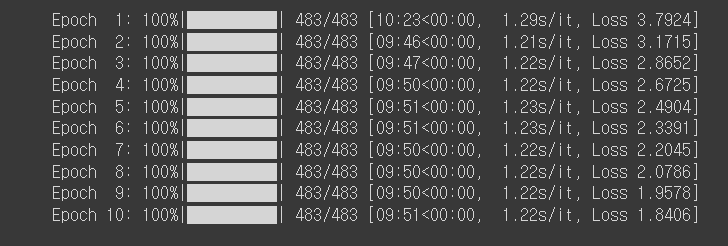

2. vocab_size = 40000
- Loss : 3.8602 > 1.7840

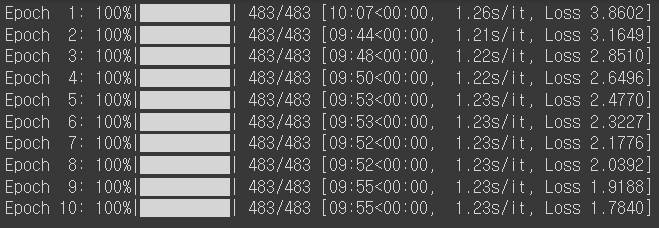



In [ ]:
# Attention Map 시각화를 제외하고 기계 번역 결과만 출력
from matplotlib import rc

def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))

  sentence = preprocessing_sentence(sentence)
  inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(
      inputs, maxlen = enc_train.shape[-1], padding='post')
  
  result = ''

  enc_out = encoder(inputs)

  dec_hidden = enc_out[:, -1]
  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    result += dec_tokenizer.index_word[predicted_id] + ' '
    
    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention

def translate_result(sentence, encoder, decdoer):
  result, sentence, attention = evaluate(sentence, encoder, decdoer)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

In [ ]:
# 해석결과 출력

test = random.sample(test_kor, 5)

for i in test:
  print(translate_result(i, encoder, decoder))
  print('-' * 50)

Input: 유엔주재 남아프리카공화국 대사인 두미사니 쿠말로는 유엔 안보리가 레바논에 특별법정을 세우는 것은 적절치 않다 고 말했다 .
Predicted translation: the korea times reports the united nations have been spotlighted as a day after wwii , and the korea times reports the united nations have been spotlighted as a day after wwii , and the korea times reports the united 
None
--------------------------------------------------
Input: 이곳은 수세기동안 차와 말을 거래하는 무역로로 중국 서부를 가로지르며 중아시아와 동남아시아의 연결고리 역할을 했다 .
Predicted translation: china is not uncommon . <end> 
None
--------------------------------------------------
Input: 서울지방경찰청 외사과는 의뢰인들이 자신의 자식들이 캐나다에서 공부할 때 학비를 면제받으려는 의도로 이 같은 행위를 저질렀다고 밝혔다 .
Predicted translation: it s not a big time <end> 
None
--------------------------------------------------
Input: 워터게이트 사건 당시 보수적인 fbi 부국장이었던 마크 펠트가 북부 캘리포니아에서 사망했습니다 .
Predicted translation: the ap s arraignment in the cleveland museum in the cleveland man suspected north carolina jury has died in the cleveland man suspected north carolina jury has died in th

In [ ]:
# Attention Map 시각화
from matplotlib import rc

def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))

  sentence = preprocessing_sentence(sentence)
  inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(
      inputs, maxlen = enc_train.shape[-1], padding='post')
  
  result = ''

  enc_out = encoder(inputs)

  dec_hidden = enc_out[:, -1]
  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    result += dec_tokenizer.index_word[predicted_id] + ' '
    
    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1,1,1)
  ax.matshow(attention, cmap = 'viridis')

  fontdict = {'fontsize' : 14}
  

  ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence, encoder, decdoer):
  result, sentence, attention = evaluate(sentence, encoder, decdoer)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence.split())]
  plot_attention(attention, sentence.split(), result.split(' '))

In [ ]:
# 폰트 불러오기
rc('font', family='NanumGothic')

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

Input: wtc 붕괴 모의실험 동영상은 유튜브에 지난 1일 등록된 후 1시간 만에 2000여 번의 조회수를 기록하며 20일 현지시간 을 기준 으로 총 조회수 12만 번을 기록하고 있다 .
Predicted translation: the second temple was launched in the city s largest passenger jet that s been meditating daily . <end> 


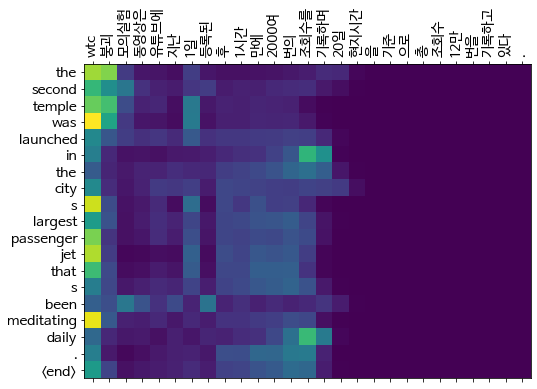

None
Input: 사망하거나 실종된 사람 중에는 , 일부 중국 국적의 노동자들을 포함하여 총 13명의 외국인 노동자와 임산부도 포함되어 있었다 .
Predicted translation: some people are not a big names of the country . <end> 


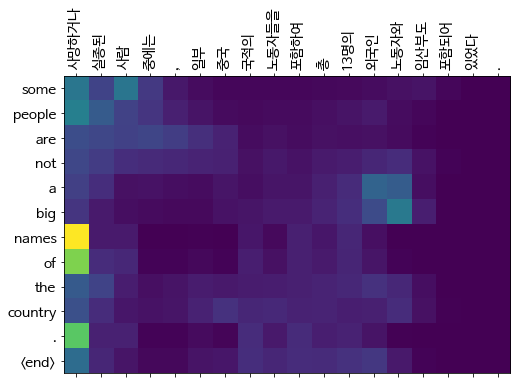

None
Input: 워터게이트 사건 당시 보수적인 fbi 부국장이었던 마크 펠트가 북부 캘리포니아에서 사망했습니다 .
Predicted translation: the ap s arraignment in the cleveland museum in the cleveland man suspected north carolina jury has died in the cleveland man suspected north carolina jury has died in the cleveland man suspected north carolina jury has died in the 


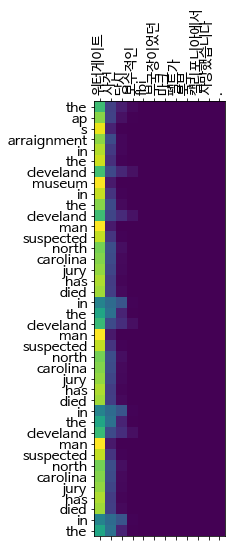

None
Input: 유엔주재 남아프리카공화국 대사인 두미사니 쿠말로는 유엔 안보리가 레바논에 특별법정을 세우는 것은 적절치 않다 고 말했다 .
Predicted translation: the korea times reports the united nations have been spotlighted as a day after wwii , and the korea times reports the united nations have been spotlighted as a day after wwii , and the korea times reports the united 


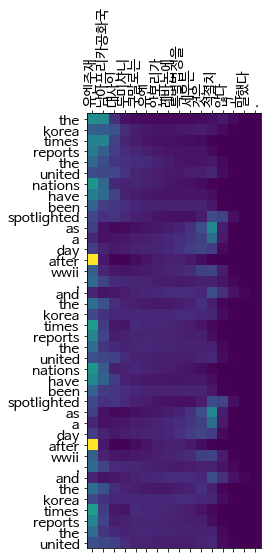

None
Input: 서울지방경찰청 외사과는 의뢰인들이 자신의 자식들이 캐나다에서 공부할 때 학비를 면제받으려는 의도로 이 같은 행위를 저질렀다고 밝혔다 .
Predicted translation: it s not a big time <end> 


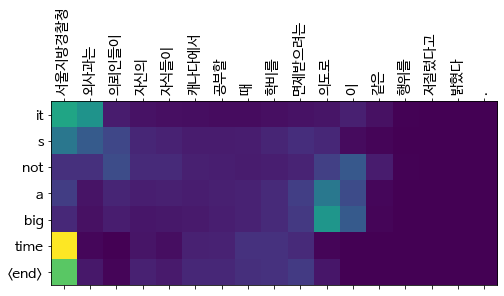

None


In [ ]:
# 해석결과 및 어텐션 맵 출력

test = random.sample(test_kor, 5)

for i in test:
  print(translate(i, encoder, decoder))

# 추가적으로 해볼 수 있는 작업

1. 기계 번역에 대한 성능을 측정하는 Bleu score 사용해보기

[BLEU Score 소개](https://jrc-park.tistory.com/273)

BLEU Score란?
- Bilingual Evaluation Understudy의 약자로 생성된 번역문이 정답 문장이랑 단어가 어느정도 일치하는지 알 수 있는 것입니다. 기계 번역 task에서 자주 사용하는 평가 지표이다.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FRCtWU%2FbtraiwW4bMF%2FryKJRXq2ArpFVvxBOeunr0%2Fimg.png)
<center>BLEU설명</center>

![]()
<center></center>

In [ ]:
# BLEU score 라이브러리 불러오기

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
# BLEU score 예시
# reference : 실제 문장
# candidate : 모델이 번역한 문장

# 모든 문장을 split한다.

reference = ['i took a hard test yesterday', 'yesterday i took a trcky test']
reference = [s.split(' ') for s in reference]
candidate = 'i took a difficult test yesterday'.split(' ')

bleu_1gram = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
bleu_2gram = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
bleu_3gram = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
bleu_4gram = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))

print(f'reference: {reference}')
print(f'candidate: {candidate}')
print(f'1-Gram BLEU: {bleu_1gram:.2f}')
print(f'2-Gram BLEU: {bleu_2gram:.2f}')
print(f'3-Gram BLEU: {bleu_3gram:.2f}')
print(f'4-Gram BLEU: {bleu_4gram:.2f}')

# 1-Gram BLEU을 해석해보면 candidate에서 reference와 겹치는 단어는 difficult를 제외한 전부이다.
# 그러므로 일치하는 단어 / 기계 번역 전체 단어이므로 5/6 = 0.83이다.

reference: [['i', 'took', 'a', 'hard', 'test', 'yesterday'], ['yesterday', 'i', 'took', 'a', 'trcky', 'test']]
candidate: ['i', 'took', 'a', 'difficult', 'test', 'yesterday']
1-Gram BLEU: 0.83
2-Gram BLEU: 0.60
3-Gram BLEU: 0.25
4-Gram BLEU: 0.00


In [ ]:
# Attention Map 시각화를 제외하고 기계 번역 결과만 출력
def translate_result_eng(sentence, encoder, decdoer):
  result, sentence, attention = evaluate(sentence, encoder, decdoer)
  # print('Predicted translation: {}'.format(result.split()))
  return result.split()

In [ ]:
# 번역 결과 출력
gen_sentence = []
test = enc_corpus[:10000]

for i in test:
 gen_sentence.append(translate_result_eng(i, encoder, decoder))

In [ ]:
# 생성 문장과 실제 문장 저장하기
# 영어 문장은 전부 띄어쓰기를 기준으로 split된 것을 사용한다.

real_sentence = sen_eng[:10000]
bleu = corpus_bleu(real_sentence, gen_sentence, weights=(1,0,0,0))

print(f'BLEU: {bleu_1gram:.4f}')

# 점수를 해석하면 기계 번역과 실제 문장의 유사서을 약 11%라고 해석할 수 있다.

BLEU: 0.1114


# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) 한국어 형태소를 문장에 적용하는 방법이 낯설어 힘들었습니다.
 - 매번 짜여진 코드를 쓰거나 keras.tokenizer를 쓰다보니 간단하게 한국어 형태소 분석기를 적용할 때 약간 어려움을 느꼈습니다.

 (2) 정교한 모델이 아니었기에 번역결과가 유사한 부분이 거의 없었습니다. 
- 문장을 일부만 추출하여 bleu score를 사용해보아지만 여전히 약 0.11이라는 낮은 점수를 보였습니다.

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) 좀 더 다양한 정규표현식 방법을 사용하게됐습니다.
- 이전에 했던 내용에 더해서 http 링크, 유니코드, 특정 문자가 포함된 전체 문장 삭제 등 정규표현식을 사용하여 시도했습니다.
- 이번 분석에는 사용하지 않았지만 중국어 및 일본어만 삭제하는 정규표현식도 알게 됐습니다.

(2) 자연어처리 평가지표 : Bleu score
- 저번에 사용한 Rouge socre말고 이번에는 Bleu score를 사용해보았습니다.
- 기계 번역에서 모델이 번역한 문장과 실제 번역문을 단어 단위로 나눠 어느정도의 유사성을 가지고 있는지 알 수 있는 방식입니다.









참조

(1) [BLEU score 참고 1](http://incredible.ai/nlp/2020/02/29/BLEU/)

(2) [BLEU score 참고 2](https://jrc-park.tistory.com/273)

